In [1]:
import pandas as pd
df = pd.read_csv('wine_dataset.csv')
df = df.drop(columns = ['Unnamed: 0', 'designation', 'region_2', 'taster_twitter_handle', 'winery'])
df = df.drop_duplicates(ignore_index=True)

for i in range(len(df)):
    num = df.loc[[i]].isna().sum().sum()
    if num >=2: 
        df.drop(i, axis = 0, inplace=True)
        
df['price'].fillna(df['price'].median(), inplace=True)
df['region_1'].fillna(str(df['region_1'].mode()), inplace=True)
df['taster_name'].fillna(0, inplace=True)

In [2]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzerObj = SentimentIntensityAnalyzer()

df['descLen'] = df['description'].map(lambda description: len(description))
df['compound'] = df['description'].map(lambda description: analyzerObj.polarity_scores(description)['compound'])
df['year'] = df['title'].map(lambda title: re.search(r"(\d{4})", title).group(1) if re.search(r"(\d{4})", title) else '0')

df = df.drop(columns = ['description', 'title'])

In [3]:
df = pd.get_dummies(df,columns=['country', 'province', 'region_1', 'taster_name', 'variety'], drop_first = True)


In [4]:
df.head()

,points,price,descLen,compound,year,country_Armenia,country_Australia,country_Austria,country_Brazil,country_Bulgaria,...,variety_Vitovska,variety_Viura,variety_Viura-Chardonnay,variety_Weissburgunder,variety_Welschriesling,variety_White Blend,variety_Xarel-lo,variety_Xinomavro,variety_Zinfandel,variety_Zweigelt
0,90,30.0,222,0.9403,2012,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87,22.0,174,0.4404,2014,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,92,50.0,268,0.6705,2012,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,93,38.0,326,0.4404,2013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,84,14.0,133,0.6908,2012,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


IMPORTS AND CLIENT SETUP

In [5]:
from py_muvr import FeatureSelector # also had to install libomp from brew

In [6]:
from dask.distributed import Client

In [7]:
client = Client()
executor = client.get_executor()

Separate predictor variables from target variable (points)

In [8]:
X = df.drop(columns=["points"]).values
y = df.points.values

Feature Selection

Estimator is the ML model used to evaluate the features.
Metrics is from scikit learn

In [9]:
estimator = "PLSR"
metric = "neg_mean_squared_error"

In [36]:
fs = FeatureSelector(
    n_outer=2,
    n_inner=2,
    n_repetitions=2,
    metric=metric,
    estimator=estimator,
    features_dropout_rate=0.05,
    random_state=1
)

In [37]:
fs.fit(X, y, executor=executor)

2021-06-16 12:56:34 py_muvr.feature_selector   INFO    Groups parameter is not specified: independent samples assumed
2021-06-16 12:56:34 py_muvr.feature_selector   INFO    Running 2 repetitions and 2 outer loops using executor ClientExecutor.
2021-06-16 12:56:34 py_muvr.feature_selector   INFO    Scheduling tasks...


100% (4 of 4) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


2021-06-16 12:56:41 py_muvr.feature_selector   INFO    Retrieving results...


100% (4 of 4) |##########################| Elapsed Time: 1:14:39 Time:  1:14:39


2021-06-16 14:11:21 py_muvr.feature_selector   INFO    Finished feature selection.


FeatureSelector(repetitions=2, n_outer=2, n_inner=2, feature_dropout_rate=0.05, is_fit=True)

In [38]:
feature_names = X = df.drop(columns=["points"]).columns

In [39]:
selected_features = fs.get_selected_features()
selected_feature_names = fs.get_selected_features(feature_names)

In [41]:
print(selected_features["min"])

[1, 0, 2, 1009, 1220, 368, 157, 35, 638, 10, 1008, 1000, 6, 1249, 1216, 73, 38, 183, 359, 1015, 803, 83, 261, 787, 1193, 325, 3, 1244, 196, 84, 397, 1076, 977, 1172, 178, 1067, 156, 1288, 250, 884, 187, 70, 987, 744, 816, 1152, 704, 1012, 821, 701, 344, 733, 1318, 801, 1006, 82, 17, 207, 624, 300, 848, 1302, 22, 547]


In [42]:
print(selected_feature_names["min"])

['descLen', 'price', 'compound', 'taster_name_Michael Schachner', 'variety_Pinot Noir', 'region_1_California', 'province_Mendoza Province', 'country_Spain', 'region_1_Mendoza', 'country_Chile', 'taster_name_Matt Kettmann', 'taster_name_Anne Krebiehl\xa0MW', 'country_Austria', 'variety_Rosé', 'variety_Pinot Grigio', 'province_California', 'country_US', 'province_Northern Spain', 'region_1_Brunello di Montalcino', 'taster_name_Virginie Boone', 'region_1_Russian River Valley', 'province_Central Valley', 'province_Virginia', 'region_1_Rioja', 'variety_Nebbiolo', 'region_1_Barolo', 'year', 'variety_Riesling', 'province_Piedmont', 'province_Champagne', 'region_1_Champagne', 'variety_Champagne Blend', 'region_1_Virginia', 'variety_Merlot', 'province_New York', 'variety_Carmenère', 'province_Maule Valley', 'variety_Tempranillo', 'province_Tuscany', 'region_1_Sta. Rita Hills', 'province_Other', 'province_Burgundy', 'region_1_Walla Walla Valley (WA)', 'region_1_Pessac-Léognan', 'region_1_Saint-J

In [43]:
feature_ranks_df = fs.get_average_ranks_df(feature_names)
feature_ranks_df.head()

,min,mid,max
price,2.0,2.0,2.0
descLen,1.0,1.0,1.0
compound,3.0,3.0,3.0
year,32.666667,38.0,35.0
country_Australia,NaN,NaN,261.0


/Users/camila/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


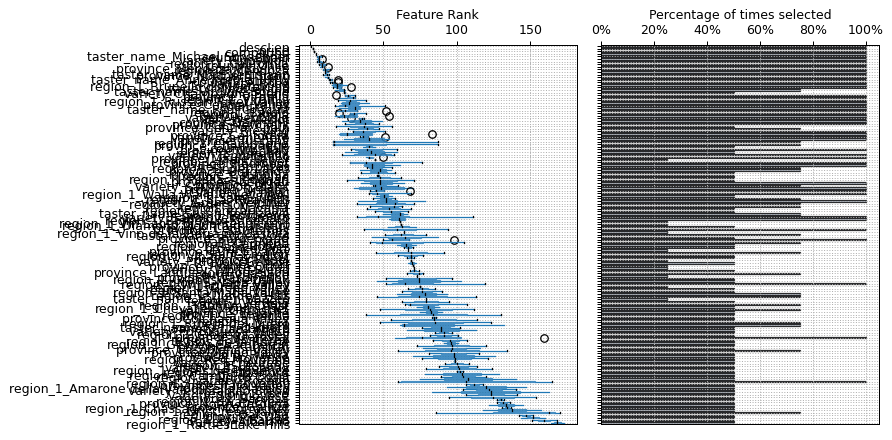

In [46]:
feature_selection_results = fs.get_feature_selection_results(feature_names)
from py_muvr.plot_utils import plot_validation_curves, plot_feature_rank


/Users/camila/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


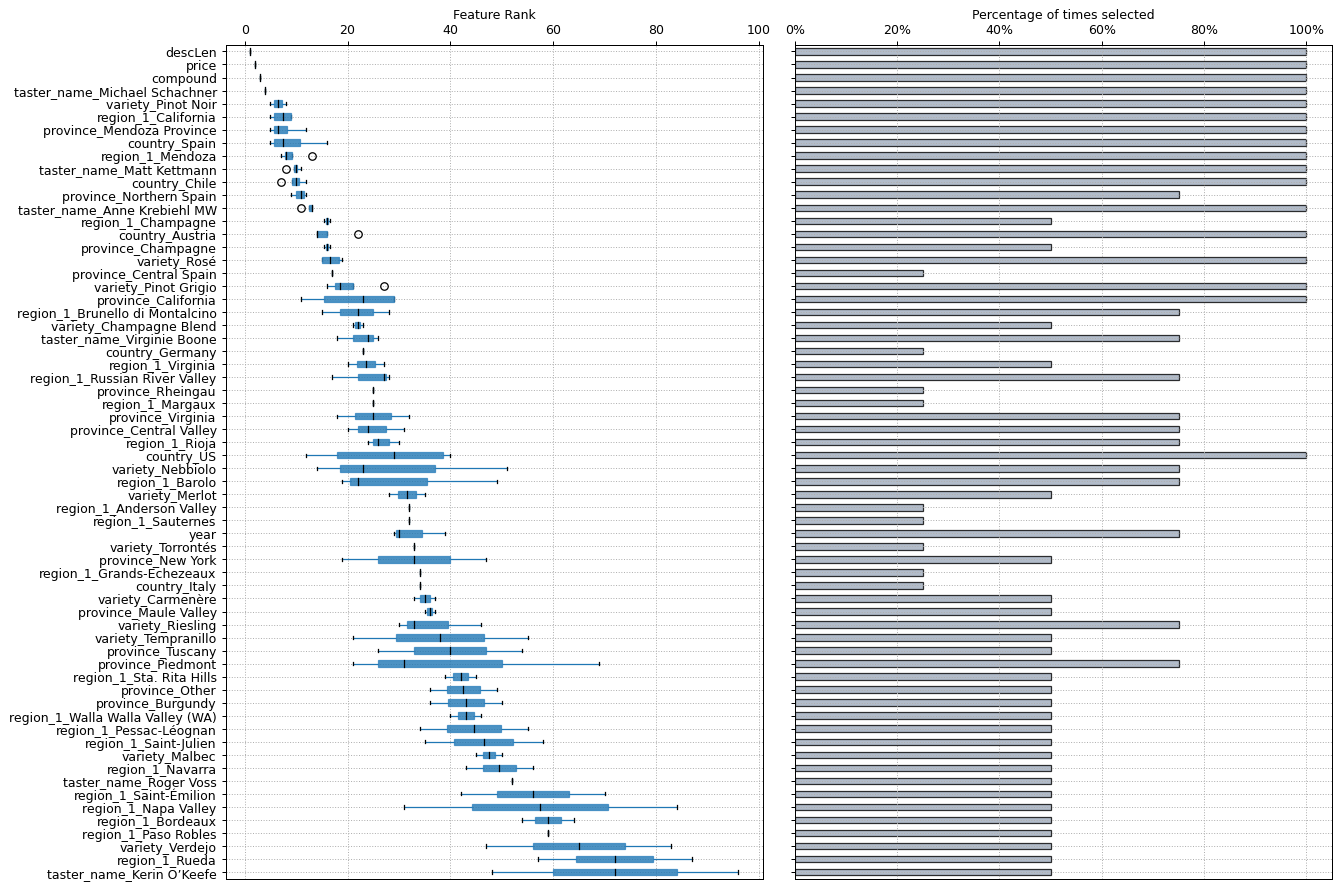

In [48]:
_ = plot_feature_rank(feature_selection_results, "min", feature_names=feature_names, figsize=(15, 10), dpi=90)